In [318]:
!pip3 install pyro-ppl
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [319]:
from graphviz import Digraph
import pyro
import torch
pyro.set_rng_seed(101)

import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter
from googlesearch import search
from ipywidgets import interactive, Layout
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import os
#os.pathsep + r'your_graphviz_bin_direction'

In [320]:
!pip install Pillow

Here are the attributes of each class:
Megaman： attack, taunt, stationary, block, dead
Shademan： attack, taunt, stationary, block, dead
Background： background
Interaction： interaction

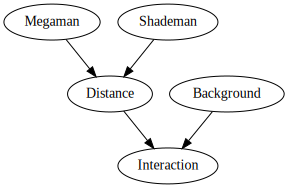

In [321]:
dag = Digraph(comment='DAG')
dag.node('M','Megaman')
dag.node('S','Shademan')
dag.node('D','Distance')
dag.node('B','Background')
dag.node('I','Interaction')
dag.edges(['MD', 'SD', 'DI', 'BI'])
dag

In [322]:
alias = {'position1':['left','right'], 
         'position2':['left','right'], 
         'action1':['attack1', 'teleport1', 'stationary1', 'hurt1','jump1', 'dead1'],
         'action2':['attack2', 'taunt2', 'stationary2', 'block2', 'dead2'],
         'backgroundcolor':['white', 'black', 'grey'],
         'distance':['small','large'],
         'background':['in the park','in the city'],
         'interaction':['fights','stationary']
        }

prob = {'position1':torch.tensor([0.5,0.5]),
        'position2':torch.tensor([0.5,0.5]), 
        'action1':torch.tensor([0.5, 0.1, 0.1, 0.1, 0.1, 0.1]),
        'action2':torch.tensor([0.3, 0.1, 0.2, 0.1, 0.3]),
        'backgroundcolor':torch.tensor([1/3,1/3,1/3]),
        'distance':torch.tensor([0.5,0.5]),
        'background':torch.tensor([0.5,0.5]),
        'interaction':torch.tensor([[[[0.97,0.03],[0.7,0.3]], #park: e1=left, [e2=left. e2=right]
                                     [[0.8,0.2],[0.97,0.03]]], #park:e1=right, [e2=left. e2=right]
                                    [[[0.96,0.04],[0.98,0.02]], #city: e1=left, [e2=left. e2=right]
                                     [[0.85,0.25],[0.9,0.1]]]]) #city: e1=right, [e2=left. e2=right]
       }
causal_var = ['position1', 'position2', 'background', 'interaction']
other_var = ['backgroundcolor', 'distance', 'action1', 'action2']
infer_var = ['position1', 'position2', 'background', 'interaction']

In [323]:
#define classes
class Background(object):
    def __init__(self):
        self.background = pyro.sample('background', dist.Categorical(prob['background']))

class Interaction(object):
    def __init__(self, entity1, entity2, background):
        self.interaction = pyro.sample('interaction', dist.Categorical(prob['interaction'][background.background][entity1.position1][entity2.position2]))
        
class Megaman(object):
    def __init__(self):
        self.position1 = pyro.sample("position1", dist.Categorical(probs=prob['position1'])) 
        self.action1 = pyro.sample("action1", dist.Categorical(probs=prob['action1'])) 
        self.backgroundcolor = pyro.sample("backgroundcolor", dist.Categorical(probs=prob['backgroundcolor']))

class Shademan(object):
    def __init__(self):
        self.position2 = pyro.sample('position2', dist.Categorical(prob['position2']))
        self.action2 = pyro.sample("action2", dist.Categorical(probs=prob['action2'])) 
        self.distance = pyro.sample('distance', dist.Categorical(prob['distance']))

In [324]:
#condition and intervention models
def model():
    '''
    This is the basic overall model, all distributions are pre-defined at the beginning, 
    and relationships are in the definition of each class.
    '''
    megaman = Megaman()
    shademan = Shademan()
    background = Background()
    interaction = Interaction(megaman, shademan, background)

def condition(model, evidence, num_samples = 1000):
    '''
    causal condition model, return posterior
    '''
    condition_model = pyro.condition(model, data=evidence)
    posterior = pyro.infer.Importance(condition_model, num_samples=num_samples).run()
    return posterior

def intervention(model, evidence, num_samples = 1000):
    '''
    causal intervention model, return posterior
    '''
    do_model = pyro.do(model, data=evidence)
    posterior = pyro.infer.Importance(do_model, num_samples=num_samples).run()
    return posterior

def pltDistribution(posterior, infer, num_samples = 1000):
    '''
    This function uses posterior from model to generated samples and plot the distribution of inference variables.
    '''
    sample = []
    for i in range(num_samples):
        trace = posterior()
        value = []
        for i in range(len(infer)):
            value.append(int(trace.nodes[infer[i]]['value']))
        sample.append(tuple(value))
        
    data = Counter(sample).most_common()
    unique = list(map(lambda x: x[0], data)) 
    counts = list(map(lambda x: x[1], data))

    x_label = []
    for i in range(len(unique)):
        label = []
        for j in range(len(infer)):
            label.append(alias[infer[j]][list(unique[i])[j]])
        x_label.append(label)

    plt.bar(range(len(data)), counts)
    plt.xticks(range(len(data)), x_label)
    plt.xlabel(infer)

def mostOccurance(posterior, infer, num_samples = 1000):
    '''
    This function takes the posterior from model and generated samples, then return the sample with most occurance.
    '''
    sample = []
    for i in range(num_samples): 
        trace = posterior()
        value = []
        for i in range(len(infer)):
            value.append(int(trace.nodes[infer[i]]['value']))
        sample.append(tuple(value))

    most_common, num_most_common = Counter(sample).most_common(1)[0]
    
    infer_dict = {}
    for i in range(len(infer)):
        infer_dict[infer[i]] = most_common[i]
    return infer_dict

In [325]:
#assistant functions
def getVar(w):
    '''
    This function takes all variables which have pre-defined values, 
    distinguishes them into causal model related variables and other variables,
    and converts label strings to torch.tensor().
    '''
    do_var = w.kwargs
    do_causal_var = {}
    do_other_var = {}
    for var in causal_var:
        if do_var[var] == '-':
            continue
        else:
            do_causal_var[var] = torch.tensor(alias[var].index(do_var[var]))
    for var in other_var:
        if do_var[var] == '-':
            continue
        else:
            do_other_var[var] = torch.tensor(alias[var].index(do_var[var]))
    return do_causal_var, do_other_var

def getInfer(do_causal_var):
    '''
    This function removes variables that has pre-defined values from all potential inference
    variables. It aims to only take variables which do not have pre-defined values as inferences 
    in our model.
    '''
    infer_all = infer_var.copy()
    do_causal_var_key = list(do_causal_var.keys())
    for var in do_causal_var_key:
        if var in infer_all:
            infer_all.remove(var)
    return infer_all

def getLabel(infer_res):
    '''
    This function convert torch.tensor() to label string for the dictionary with all variables.
    '''
    for key in infer_res:
        infer_res[key] = alias[key][infer_res[key]]
    return infer_res

def getEntity(input_dic):
    '''
    This function generates samples with pre-defined class and functions,
    and replace variables which have pre-defined values or infered from 
    our causal model.
    Return a dictionary with all variables with a label.
    '''
    dic = {}
    megaman = Megaman()
    shademan = Shademan()
    background = Background()
    interaction = Interaction(megaman,shademan,background)
    entity_list = [megaman,shademan,background,interaction]
    for k in entity_list:
        entity_dic = k.__dict__
        dic.update(entity_dic)
        
    for k in dic:
        dic[k] = alias[k][dic[k]]
    dic.update(input_dic)
    return dic

def getScene(input_dict):
    '''
    This function takes the output dictionary with all variable,
    and converts it into a sentence and print it out.
    '''
    scene = str("The megaman with %s and shademan with %s %s in a scene from %s in the %s." % 
                (input_dict['action1'],input_dict['action2'],
                 input_dict['interaction'],input_dict['distance'],
                 input_dict['background']))
    print(scene)
    return scene

def userInterface():
    '''
    This function allows user to do condition and intervention with a user interface.
    display(w) shows the interface.
    '''
    # Part 1: multiple choices of label values
    def f_interactive(position1,position2,backgroundcolor,action1,action2,distance,background,interaction):
        pass

    w = interactive(f_interactive, 
                       position1=sum([["-"],alias['position1']], []),
                       position2=sum([["-"],alias['position2']], []),
                       action1=sum([["-"],alias['action1']], []),
                       action2=sum([["-"],alias['action2']], []),
                       backgroundcolor=sum([["-"],alias['backgroundcolor']], []),
                       distance=sum([["-"],alias['distance']], []),
                       background=sum([["-"],alias['background']], []),
                       interaction=sum([["-"],alias['interaction']], []))
    
    # Part 2: button to show pictures
    btn_con = widgets.Button(description = "Show conditional picture", tooltip = 'condition button', layout=Layout(width='25%', height='40px'))
    btn_do = widgets.Button(description = "Show interventional picture", tooltip = 'intervention button', layout=Layout(width='25%', height='40px'))
    def btn_con_click(sender):
        final_dict, scene = model_condition(w, False)
        pic = generatePic(final_dict, scene)
        display(pic.finalImage)
        pic.save()
    def btn_do_click(sender):
        final_dict, scene = model_intervention(w, False)
        pic = generatePic(final_dict, scene)
        display(pic.finalImage)
        pic.save()
    btn_con.on_click(btn_con_click)
    btn_do.on_click(btn_do_click)

    return w, btn_con, btn_do
    

In [326]:
#main functions
def model_condition(w, plot = False): 
    do_causal_var, do_other_var = getVar(w)
    infer = getInfer(do_causal_var)
    infer_model = condition(model, evidence = do_causal_var)
    do_causal_var.update(do_other_var)
    infer_res = {}
    if infer:
        if plot:
            pltDistribution(infer_model, infer)
        infer_res = mostOccurance(infer_model, infer)
    infer_res.update(do_causal_var)
    infer_res = getLabel(infer_res)
    final_dict = getEntity(infer_res)
    scene = getScene(final_dict)
    return final_dict, scene


def model_intervention(w, plot = False):
    do_causal_var, do_other_var = getVar(w)
    infer = getInfer(do_causal_var)
    infer_model = intervention(model, evidence = do_causal_var)
    do_causal_var.update(do_other_var)
    infer_res = {}
    if infer:
        if plot:
            pltDistribution(infer_model, infer)
        infer_res = mostOccurance(infer_model, infer)
    infer_res.update(do_causal_var)
    infer_res = getLabel(infer_res)
    final_dict = getEntity(infer_res)
    scene = getScene(final_dict)
    return final_dict, scene

In [333]:
#image generator
class generatePic(object):
    '''
    This class takes generated features from causal OOP model and implements it into a picture.
    '''
    def __init__(self, attr_dict, scene):
        self.position1 = attr_dict['position1']
        self.position2 = attr_dict['position2']
        self.action1 = attr_dict['action1']
        self.action2 = attr_dict['action2']
        self.distance = attr_dict['distance']
        self.backgroundcolor = attr_dict['backgroundcolor']
        self.background = attr_dict['background']
        self.scene = scene
        self.MegamanImage, self.ShademanImage, self.backgroundImage = self.getImage()
        self.finalImage = self.getFinalImage()

    def getImage(self):
        '''
        load raw pictures as elements from local directory
        '''
        try:
            im_g = Image.open("/content/drive/My Drive/Causal modelling/Causal scene generation/"+self.action1+".png")
        except:
            im_g = Image.open("/content/drive/My Drive/Causal modelling/Causal scene generation/"+self.action1+".jpg")
        try:
            im_t = Image.open("/content/drive/My Drive/Causal modelling/Causal scene generation/"+self.action2+".png")
        except:
            im_t = Image.open("/content/drive/My Drive/Causal modelling/Causal scene generation/"+self.action2+".jpg")
        try:
            im_b = Image.open("/content/drive/My Drive/Causal modelling/Causal scene generation/"+self.background+".png")
        except:
            im_b = Image.open("/content/drive/My Drive/Causal modelling/Causal scene generation/"+self.background+".jpg")
        return im_g, im_t, im_b

    def backgroundcolor(self):
        color = self.color
        rgb_dict = {'black': (0, 0, 0),
                   'grey': (165, 169, 176),
                   'white': (179, 120, 61)}
        self.backgroundImage = self.backgroundImage.convert('RGBA')
        data = np.array(self.backgroundImage)
        red, green, blue, alpha = data.T

        white_areas = (red == 255) & (blue == 255) & (green == 255)
        data[..., :-1][~white_areas.T] = rgb_dict[color]

        self.animalImage = Image.fromarray(data)

    def getdistance(self):
        if self.distance == 'small':
            rt = [0.3, 0.7]
        else:
            rt = [0.5, 0.8]
        return rt
    
    def resize_pic(self, entityImage, rt = [0.5,0.8]):
        '''
        resize entities' (person's and animal's) pictures to adjust the background
        '''
        maxwidth, maxheight = self.backgroundImage.width*rt[0], self.backgroundImage.height*rt[1]
        new_w = entityImage.width
        new_h = entityImage.height
        if entityImage.width>=maxwidth:
            new_w = int(maxwidth)
            ratio = entityImage.height/entityImage.width
            new_h = int(new_w*ratio)
        if entityImage.height>=maxheight:
            new_h = int(maxheight)
            ratio = entityImage.height/entityImage.width
            new_w = int(new_h/ratio)
        entityImage_new = entityImage.resize((new_w,new_h))
        return entityImage_new      
    
    def get_concat(self, color=(255,255,255)):
        '''
        combine person's, animal's and background's picture into one picture
        '''
        if self.position1 == self.position2:
            dis = 0
        else:
            dis = 100
        image = Image.new('RGBA', self.backgroundImage.size ,color)
        image.paste(self.backgroundImage,(0,0))
        if self.position1 == 'right' and self.position2 == 'left':
            leftImage = self.MegamanImage
            rightImage = self.ShademanImage
        else:
            leftImage = self.MegamanImage
            rightImage = self.ShademanImage
        image.paste(leftImage, (int((self.backgroundImage.width-dis)/2-leftImage.width), self.backgroundImage.height-leftImage.height-10))
        image.paste(rightImage, (int((self.backgroundImage.width+dis)/2-leftImage.width), self.backgroundImage.height-rightImage.height-10))
        return image
    
    def addDescription(self,image):
        l = ImageDraw.Draw(image)
        #font = ImageFont.truetype('arial.ttf', size=60);
        #l.text((50, 50), self.scene, font = font, align ="center", fill = 'black') 
        
    def getFinalImage(self):
        self.MegamanImage = self.resize_pic(self.MegamanImage, rt = [0.5,0.7])
        self.ShademanImage = self.resize_pic(self.ShademanImage, rt = self.getdistance())
        image = self.get_concat()
        self.addDescription(image)
        return image
        
    def draw(self):
        self.finalImage.show()
        
    def save(self):
        self.finalImage.save("/content/drive/My Drive/Causal modelling/Causal scene generation/generatedPic/" + self.scene + ".png")

    def getdistance(self):
        if self.distance == 'small':
            rt = [0.3, 0.7]
        else:
            rt = [0.5, 0.8]
        return rt

interactive(children=(Dropdown(description='position1', options=('-', 'left', 'right'), value='-'), Dropdown(d…

Button(description='Show conditional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle(),…

Button(description='Show interventional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle…

The megaman with dead1 and shademan with taunt2 fights in a scene from large in the in the city.


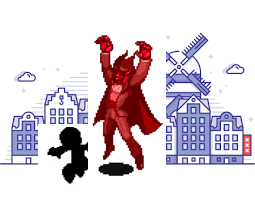

The megaman with dead1 and shademan with taunt2 fights in a scene from small in the in the city.


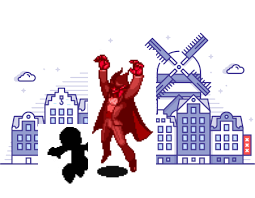

The megaman with jump1 and shademan with stationary2 fights in a scene from small in the in the park.


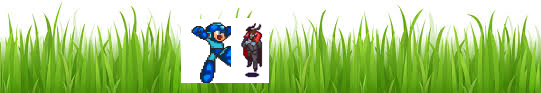

The megaman with jump1 and shademan with stationary2 fights in a scene from small in the in the park.


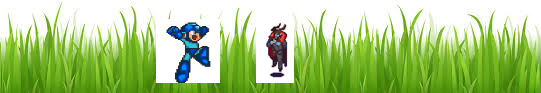

The megaman with jump1 and shademan with stationary2 fights in a scene from small in the in the park.


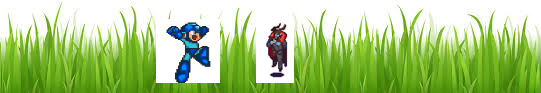

In [328]:
variable_choices, btn_condition, btn_intervention  = userInterface()
display(variable_choices, btn_condition, btn_intervention)

Button(description='Show conditional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle(),…

The megaman with jump1 and shademan with stationary2 fights in a scene from small in the in the park.


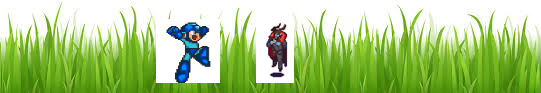

In [329]:
display(btn_condition)

Button(description='Show conditional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle(),…

The megaman with jump1 and shademan with stationary2 fights in a scene from small in the in the park.


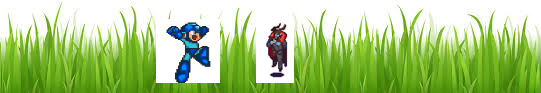

In [330]:
display(btn_condition)

In [331]:
display(btn_intervention)

Button(description='Show interventional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle…

In [332]:
display(btn_intervention)

Button(description='Show interventional picture', layout=Layout(height='40px', width='25%'), style=ButtonStyle…